In [1]:
import numpy as np
import pandas as pd

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab

import corner

import vpfits

from scipy.signal import savgol_filter

In [2]:
import pymc

In [3]:
def plot_bracket(x, axis, dir):
    height = .2
    arm_length = 0.2
    axis.plot((x, x), (1-height/2, 1+height/2), color='magenta')

    if dir=='left':
        xarm = x+arm_length
    if dir=='right':
        xarm = x-arm_length

    axis.plot((x, xarm), (1-height/2, 1-height/2), color='magenta')
    axis.plot((x, xarm), (1+height/2, 1+height/2), color='magenta')


# Observed Spectrum

Here we test VAMP on a spectrum measured from quasar Q1422+231, at redshift 3.62.

In [4]:
cont = np.loadtxt('data/q1422.cont')

In [5]:
vpm = pd.read_table('data/q1422.vpm', skiprows=2, header=None, delim_whitespace=True)
vpm.columns = ['index', 'optical_depth', 'velocity', 'b', 'err_o', 
               'err_v', 'err_b', 'equivalentWidth_AA', 'wavelength_AA']

vpm

,index,optical_depth,velocity,b,err_o,err_v,err_b,equivalentWidth_AA,wavelength_AA
0,1,102.54,-31639.4,29.68,33.55,23.83,8.77,0.456,5029.091
1,2,6.44,-31533.4,18.81,2.65,36.80,40.44,0.171,5031.079
2,3,26.88,-31117.1,41.68,3.78,3.24,2.31,0.474,5038.887
3,4,11.87,-28365.1,18.54,5.24,2.41,1.34,0.211,5090.500
4,5,0.63,-25795.6,48.22,0.34,17.14,13.27,0.033,5138.689
5,6,16.52,-31574.1,63.25,53.85,10.77,32.47,0.502,5030.315
6,7,36.00,-25403.0,35.46,0.81,0.49,0.37,0.452,5146.053
7,8,0.23,-24860.4,25.02,0.04,2.72,3.45,0.012,5156.228
8,9,24.38,-24199.1,22.31,0.51,0.04,0.22,0.289,5168.631
9,10,38.37,-23883.6,25.35,7.33,1.47,1.86,0.349,5174.548


In [6]:
vpfit = vpfits.VPfit()

## Region Detection

We perform region detection on the entire spectrum, dividing it into regions to be fitted.

In [7]:
run_region = (cont[:,0] > vpm['wavelength_AA'].min() - 10) & (cont[:,0] < vpm['wavelength_AA'].max() + 10) 

min_region_width = 2

regions = vpfits.compute_detection_regions(cont[run_region,0], cont[run_region,2], cont[run_region,3], 
                                          min_region_width=min_region_width)

Computing detection regions...
Found 66 detection regions.


In [8]:
region_arrays = []
region_pixels = []
for region in regions:
    start = np.where(cont[run_region,0] == region[0])[0][0]
    end = np.where(cont[run_region,0] == region[1])[0][0]
    region_pixels.append([start, end])
    region_arrays.append([cont[run_region,0][start:end], cont[run_region,2][start:end]])

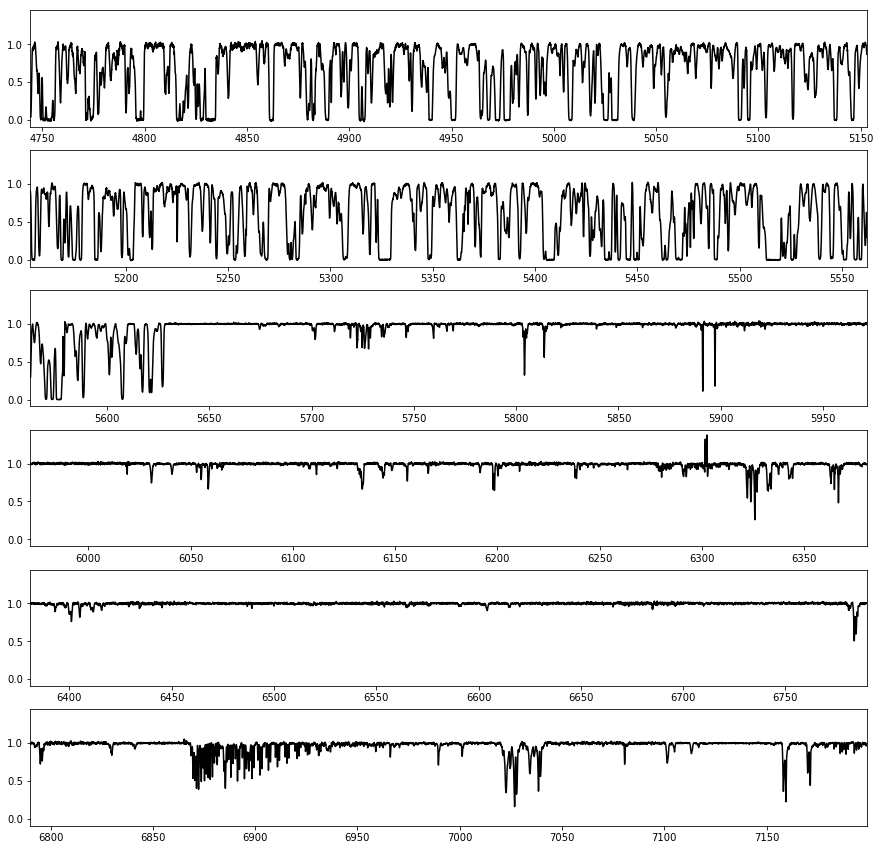

In [9]:
N = 6
fig, ax = plt.subplots(N, figsize=(15,15))

for n in range(N):
    length = len(cont) / N
    
    lower_lim = n*length
    upper_lim = n*length+length
    
#     ax[n].vlines(vpm[(vpm['wavelength_AA'] > cont[:,0][lower_lim]) \
#                         & (vpm['wavelength_AA'] < cont[:,0][upper_lim])]['wavelength_AA'], 0, 1.2, color='green')
    
    ax[n].plot(cont[:,0], cont[:,2], c='black')
    
    ax[n].set_xlim(cont[:,0][lower_lim], cont[:,0][upper_lim])

#     for arr in region_arrays:
#         ax[n].plot(arr[0], arr[1], color='blue')

#     for (start, end) in region_pixels:
#         plot_bracket(cont[:,0][start], ax[n], 'left')
#         plot_bracket(cont[:,0][end], ax[n], 'right')

plt.show()

## Fit a single region

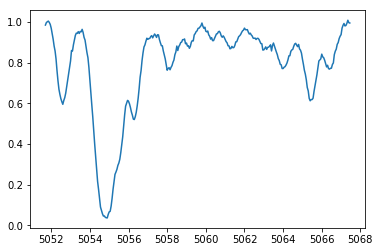

In [12]:
i = 5

wavelength_array = region_arrays[i][0]
flux_array = region_arrays[i][1]

plt.plot(wavelength_array, flux_array)

In [13]:
vpfit = vpfits.VPfit()

In [14]:
window=11

local_minima = vpfit.find_local_minima(flux_array, window=window)

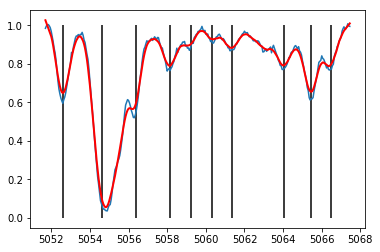

In [15]:
pylab.plot(wavelength_array, flux_array)
pylab.plot(wavelength_array, savgol_filter(flux_array, window, 1), 'red', lw=2)

pylab.vlines(wavelength_array[local_minima], 0, 1)

In [14]:
n = len(local_minima) + 3

vpfit.initialise_model(wavelength_array, flux_array, n, local_minima, voigt=True)

Initialising Voigt profile components.


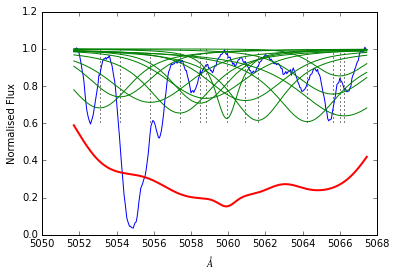

In [15]:
f, ax = plt.subplots()

ax.plot(wavelength_array, flux_array)

for c in range(len(vpfit.estimated_profiles)):
    ax.plot(wavelength_array, vpfit.Absorption(vpfit.estimated_profiles[c].value),
             color="green")
    
plt.vlines([x['centroid'].value for x in vpfit.estimated_variables.values()],
           1, vpfit.Absorption(np.array([x['amplitude'].value for x in vpfit.estimated_variables.values()])),
           linestyles='dotted')

#plt.vlines(wavelength_array[local_minima], 0, 1, linestyles='dashdot')

plt.plot(wavelength_array, vpfit.total.value, color='red', linewidth=2.0)

plt.xlabel('$\AA$')
plt.ylabel('Normalised Flux')

In [16]:
vpfit.map_estimate()

Computing the Maximum A Posteriori estimate...


In [17]:
vpfit.MAP.BIC

1048.2879917129867

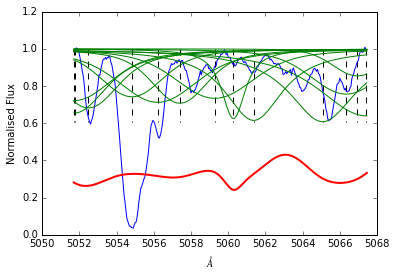

In [18]:
f, ax = plt.subplots()

ax.plot(wavelength_array, flux_array)

for c in range(len(vpfit.estimated_profiles)):
    ax.plot(wavelength_array, vpfit.Absorption(vpfit.estimated_profiles[c].value),
             color="green")
    
plt.vlines([x['centroid'].value for x in vpfit.estimated_variables.values()],
           1, vpfit.Absorption(np.array([x['amplitude'].value for x in vpfit.estimated_variables.values()])),
           linestyles='dashed')

plt.plot(wavelength_array, vpfit.total.value, color='red', linewidth=2.0)

plt.xlabel('$\AA$')
plt.ylabel('Normalised Flux')

In [19]:
vpfit.mcmc_fit(iterations=10000, burnin=6000)

Using Metropolis step method for each parameter.
 [-----------------100%-----------------] 10000 of 10000 complete in 204.4 sec
Took: 0:03:24.447023  to finish.


In [20]:
vpfit.mcmc.BPIC

-2056.358498221698

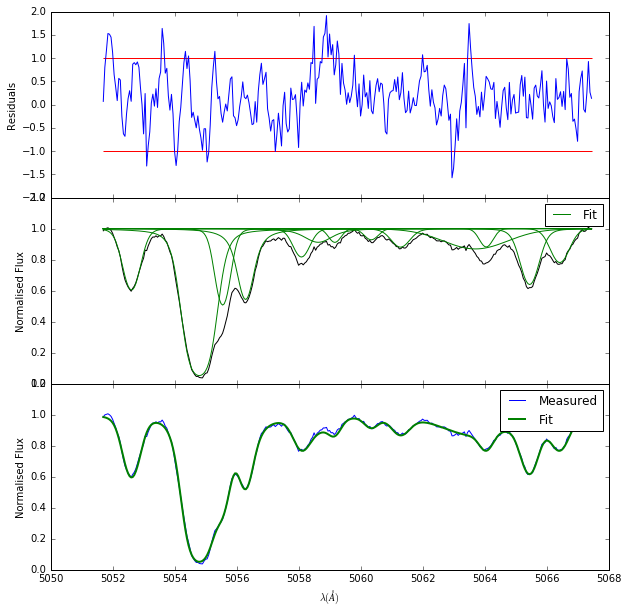

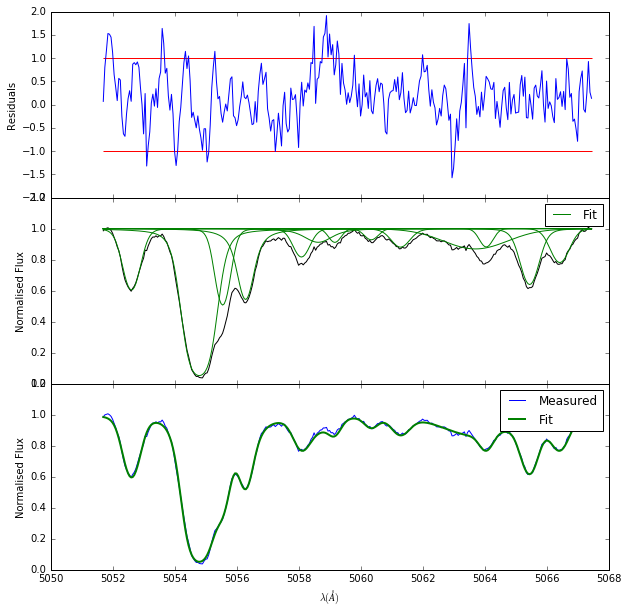

In [21]:
vpfit.plot(wavelength_array, flux_array, local_minima, n=n)

In [28]:
vpfit.estimated_variables

{0: {'G': <pymc.distributions.Uniform 'est_G_0' at 0x7f24db722a10>,
  'L': <pymc.distributions.Uniform 'est_L_0' at 0x7f24d9e8ed50>,
  'amplitude': <pymc.PyMCObjects.Stochastic 'xexp_0' at 0x7f24d9e980d0>,
  'centroid': <pymc.distributions.Normal 'est_centroid_0' at 0x7f24d9e98110>},
 1: {'G': <pymc.distributions.Uniform 'est_G_1' at 0x7f24d9e8ed90>,
  'L': <pymc.distributions.Uniform 'est_L_1' at 0x7f24d9e8e8d0>,
  'amplitude': <pymc.PyMCObjects.Stochastic 'xexp_1' at 0x7f24db722850>,
  'centroid': <pymc.distributions.Normal 'est_centroid_1' at 0x7f24db7be610>},
 2: {'G': <pymc.distributions.Uniform 'est_G_2' at 0x7f24d9e8e7d0>,
  'L': <pymc.distributions.Uniform 'est_L_2' at 0x7f24d9e8e650>,
  'amplitude': <pymc.PyMCObjects.Stochastic 'xexp_2' at 0x7f24d9e8e610>,
  'centroid': <pymc.distributions.Normal 'est_centroid_2' at 0x7f24d9e8e850>},
 3: {'G': <pymc.distributions.Uniform 'est_G_3' at 0x7f24d9e8e210>,
  'L': <pymc.distributions.Uniform 'est_L_3' at 0x7f24d9e8e110>,
  'amplitude

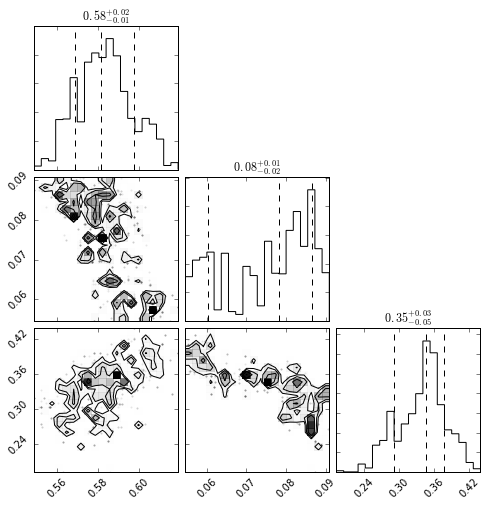

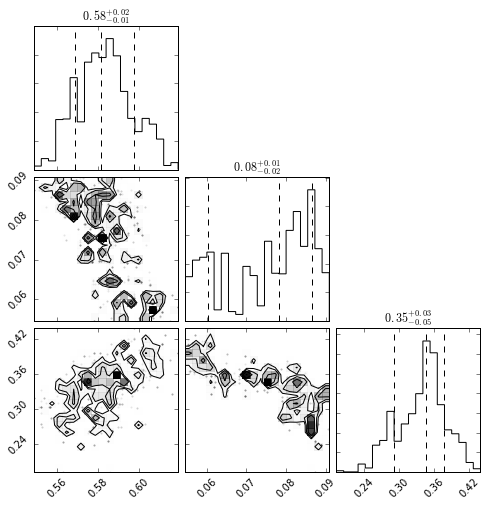

In [53]:
data = np.vstack([vpfit.mcmc.trace('est_G_0')[:], 
                  vpfit.mcmc.trace('est_L_0')[:], 
                  vpfit.mcmc.trace('est_G_2')[:]]).T

corner.corner(data, quantiles=[0.16, 0.5, 0.84], show_titles=True)

In [41]:

ndim, nsamples = 2, 10000
np.random.seed(42)
samples = np.random.randn(ndim * nsamples).reshape([nsamples, ndim])

In [43]:
samples.shape

(10000, 2)

## Fit all the regions

Fit only the region covered by previously identified features.

We fit each region separately, determining the optimal number of profiles to fit with.

In [142]:
run_region = (cont[:,0] > vpm['wavelength_AA'].min() - 10) & (cont[:,0] < vpm['wavelength_AA'].max() + 10) 

In [21]:
min_region_width = 2

regions = vpfits.compute_detection_regions(cont[run_region,0], cont[run_region,2], cont[run_region,3], 
                                          min_region_width=min_region_width)

Computing detection regions...
Found 66 detection regions.


In [22]:
region_arrays = []
region_pixels = []
for region in regions:
    start = np.where(cont[run_region,0] == region[0])[0][0]
    end = np.where(cont[run_region,0] == region[1])[0][0]
    region_pixels.append([start, end])
    region_arrays.append([cont[run_region,0][start:end], cont[run_region,2][start:end]])

Plot the regions

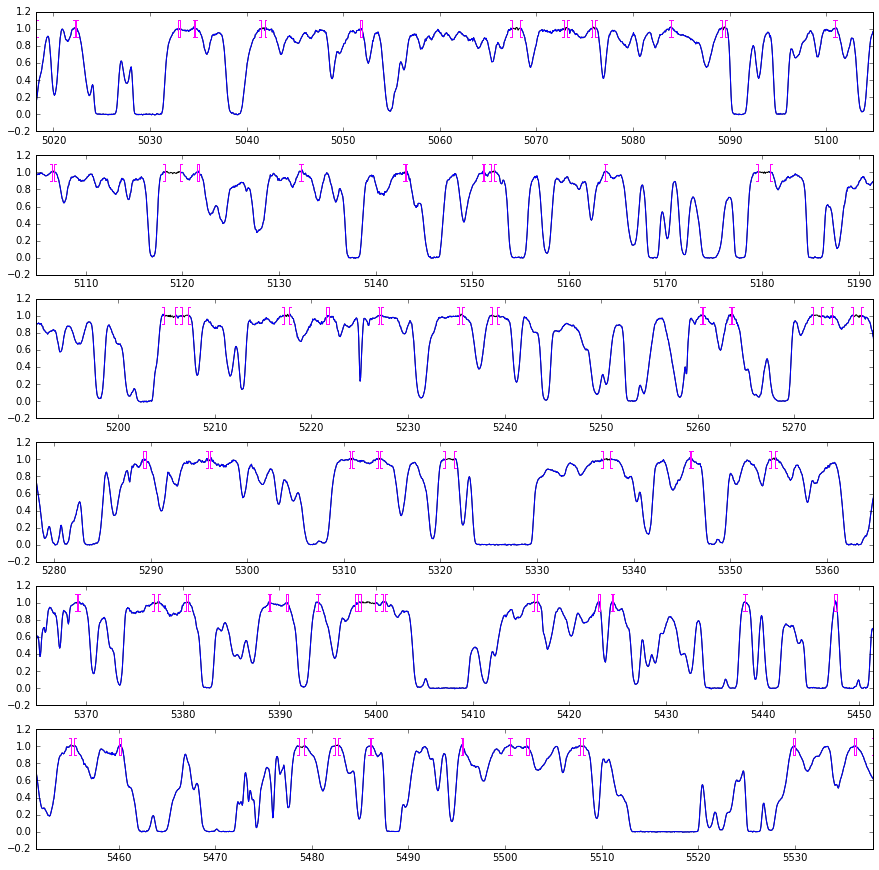

In [25]:
N = 6
fig, ax = plt.subplots(N, figsize=(15,15))

for n in range(N):
    length = sum(run_region) / N
    
    lower_lim = n*length
    upper_lim = n*length+length
    
#     ax[n].vlines(vpm[(vpm['wavelength_AA'] > cont[run_region,0][lower_lim]) \
#                     & (vpm['wavelength_AA'] < cont[run_region,0][upper_lim])]['wavelength_AA'], 
#                  vpfit.Absorption(vpm[(vpm['wavelength_AA'] > cont[run_region,0][lower_lim]) \
#                     & (vpm['wavelength_AA'] < cont[run_region,0][upper_lim])]['optical_depth']),
#                  1.2, color='green')
    
    ax[n].plot(cont[run_region,0], cont[run_region,2], c='black')
    
    ax[n].set_xlim(cont[run_region,0][lower_lim], cont[run_region,0][upper_lim])

    for arr in region_arrays:
        ax[n].plot(arr[0], arr[1], color='blue')

    for (start, end) in region_pixels:
        plot_bracket(cont[run_region,0][start], ax[n], 'left')
        plot_bracket(cont[run_region,0][end], ax[n], 'right')

plt.show()

Fit

n: 1
Initialising Voigt profile components.
Computing the Maximum A Posteriori estimate...
n:  2
Initialising Voigt profile components.
Computing the Maximum A Posteriori estimate...
Fit 1 BIC:  -189.9509739 , Fit 2 BIC:  62.2873986718
BIC Ratio:  -3.0495891296
n:  3
Initialising Voigt profile components.
Computing the Maximum A Posteriori estimate...
Fit 1 BIC:  62.2873986718 , Fit 2 BIC:  45.4078286404
BIC Ratio:  1.37173259627
n (final):  2
Using Metropolis step method for each parameter.
 [-----------------100%-----------------] 10000 of 10000 complete in 24.1 sec
Took: 0:00:24.137461  to finish.


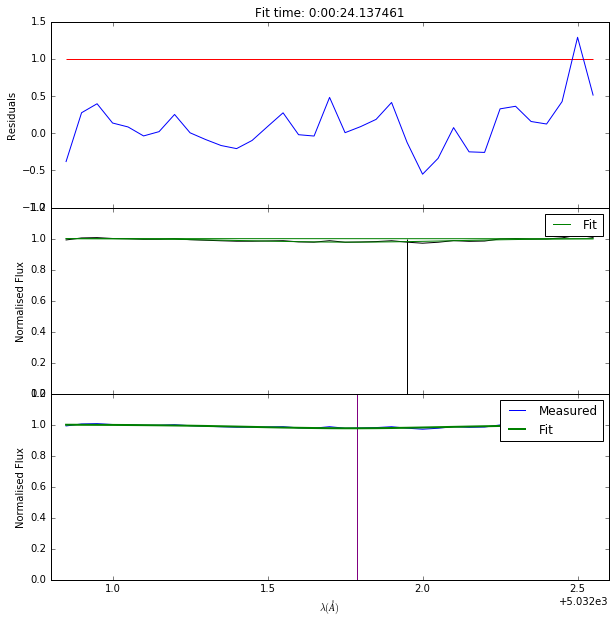

n: 3
Initialising Voigt profile components.
Computing the Maximum A Posteriori estimate...
n:  4
Initialising Voigt profile components.
Computing the Maximum A Posteriori estimate...
Fit 1 BIC:  -15.7148720261 , Fit 2 BIC:  119.010899905
BIC Ratio:  -0.132045653286
n:  5
Initialising Voigt profile components.
Computing the Maximum A Posteriori estimate...
Fit 1 BIC:  119.010899905 , Fit 2 BIC:  292.696690754
BIC Ratio:  0.406601453532
n:  6
Initialising Voigt profile components.
Computing the Maximum A Posteriori estimate...
Fit 1 BIC:  292.696690754 , Fit 2 BIC:  451.43492586
BIC Ratio:  0.648369618714
n:  7
Initialising Voigt profile components.
Computing the Maximum A Posteriori estimate...
Fit 1 BIC:  451.43492586 , Fit 2 BIC:  152.458577564
BIC Ratio:  2.9610333054
n (final):  6
Using Metropolis step method for each parameter.
 [-----------------100%-----------------] 10000 of 10000 complete in 82.9 sec
Took: 0:01:22.914494  to finish.


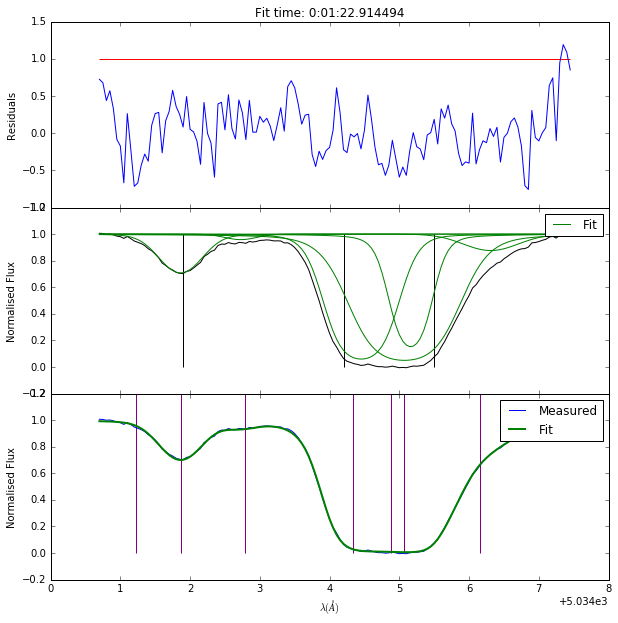

n: 5
Initialising Voigt profile components.
Computing the Maximum A Posteriori estimate...
n:  6
Initialising Voigt profile components.
Computing the Maximum A Posteriori estimate...
Fit 1 BIC:  186.558179972 , Fit 2 BIC:  386.361004693
BIC Ratio:  0.482859754752
n:  7
Initialising Voigt profile components.
Computing the Maximum A Posteriori estimate...
Fit 1 BIC:  386.361004693 , Fit 2 BIC:  417.516934255
BIC Ratio:  0.92537804576
n:  8
Initialising Voigt profile components.
Computing the Maximum A Posteriori estimate...
Fit 1 BIC:  417.516934255 , Fit 2 BIC:  674.937286398
BIC Ratio:  0.618601079936
n:  9
Initialising Voigt profile components.
Computing the Maximum A Posteriori estimate...
Fit 1 BIC:  674.937286398 , Fit 2 BIC:  603.308919308
BIC Ratio:  1.1187258547
n (final):  8
Using Metropolis step method for each parameter.
 [-----------------100%-----------------] 10000 of 10000 complete in 133.7 sec
Took: 0:02:13.711352  to finish.


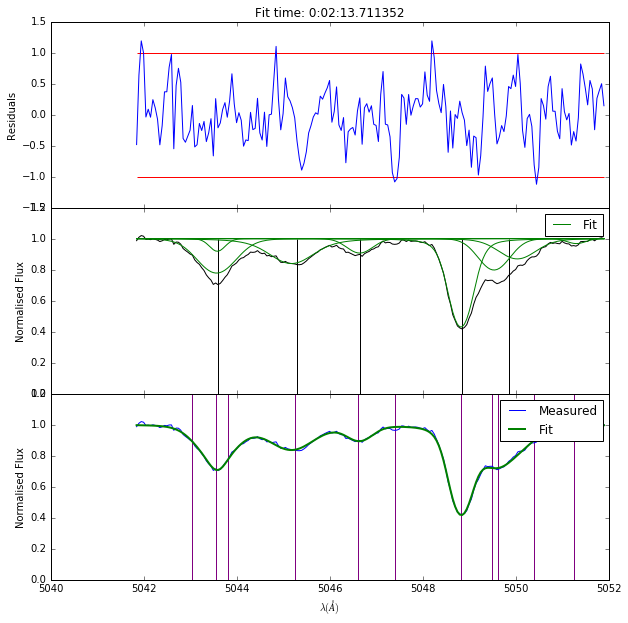

n: 10
Initialising Voigt profile components.
Computing the Maximum A Posteriori estimate...
n:  11
Initialising Voigt profile components.
Computing the Maximum A Posteriori estimate...
Fit 1 BIC:  453.010852646 , Fit 2 BIC:  773.181093713
BIC Ratio:  0.585905237893
n:  12
Initialising Voigt profile components.
Computing the Maximum A Posteriori estimate...
Fit 1 BIC:  773.181093713 , Fit 2 BIC:  933.384874598
BIC Ratio:  0.828362570205
n:  13
Initialising Voigt profile components.
Computing the Maximum A Posteriori estimate...
Fit 1 BIC:  933.384874598 , Fit 2 BIC:  820.334409309
BIC Ratio:  1.13781021984
n (final):  12
Using Metropolis step method for each parameter.
 [-----------------100%-----------------] 10000 of 10000 complete in 300.5 sec
Took: 0:05:00.487725  to finish.


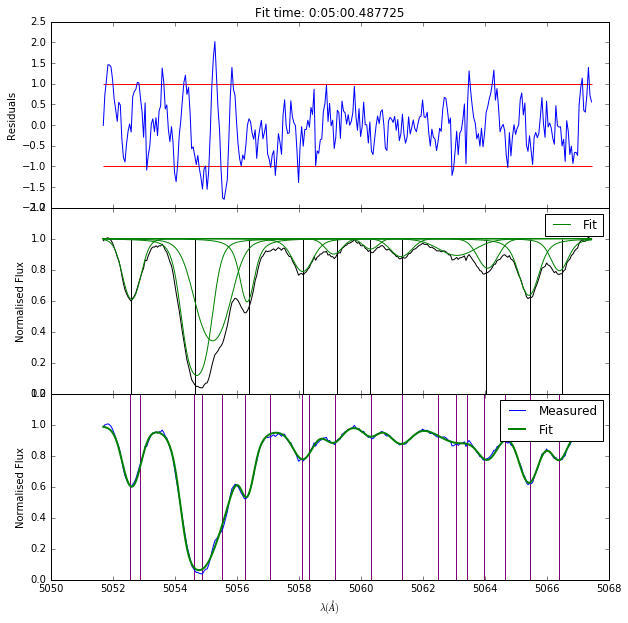

n: 2
Initialising Voigt profile components.
Computing the Maximum A Posteriori estimate...
n:  3
Initialising Voigt profile components.
Computing the Maximum A Posteriori estimate...
Fit 1 BIC:  -86.7351359113 , Fit 2 BIC:  44.4471414531
BIC Ratio:  -1.95142214045
n:  4
Initialising Voigt profile components.
Computing the Maximum A Posteriori estimate...
Fit 1 BIC:  44.4471414531 , Fit 2 BIC:  235.361979092
BIC Ratio:  0.188845885918
n:  5
Initialising Voigt profile components.
Computing the Maximum A Posteriori estimate...
Fit 1 BIC:  235.361979092 , Fit 2 BIC:  114.822074053
BIC Ratio:  2.04979731497
n (final):  4
Using Metropolis step method for each parameter.
 [-----------------100%-----------------] 10000 of 10000 complete in 57.8 sec
Took: 0:00:57.811921  to finish.


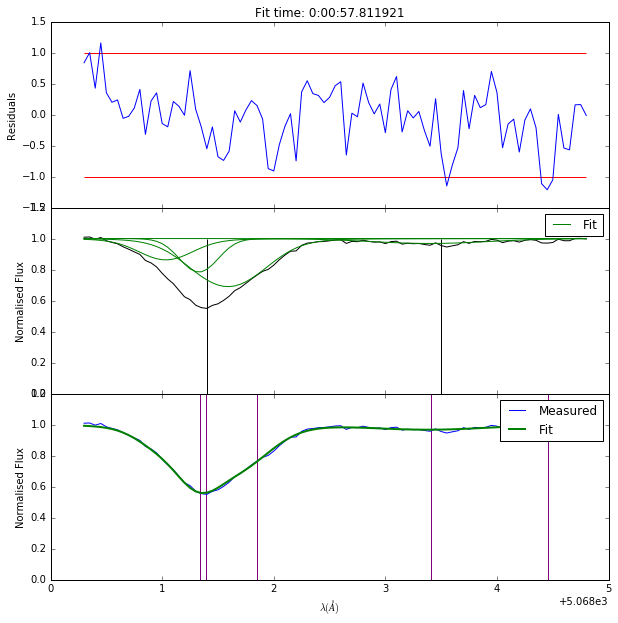

n: 1
Initialising Voigt profile components.
Computing the Maximum A Posteriori estimate...
n:  2
Initialising Voigt profile components.
Computing the Maximum A Posteriori estimate...
Fit 1 BIC:  -168.17148153 , Fit 2 BIC:  -36.2481176289
BIC Ratio:  4.63945419874
n (final):  1
Using Metropolis step method for each parameter.
 [-----------------100%-----------------] 10000 of 10000 complete in 15.4 sec
Took: 0:00:15.416355  to finish.


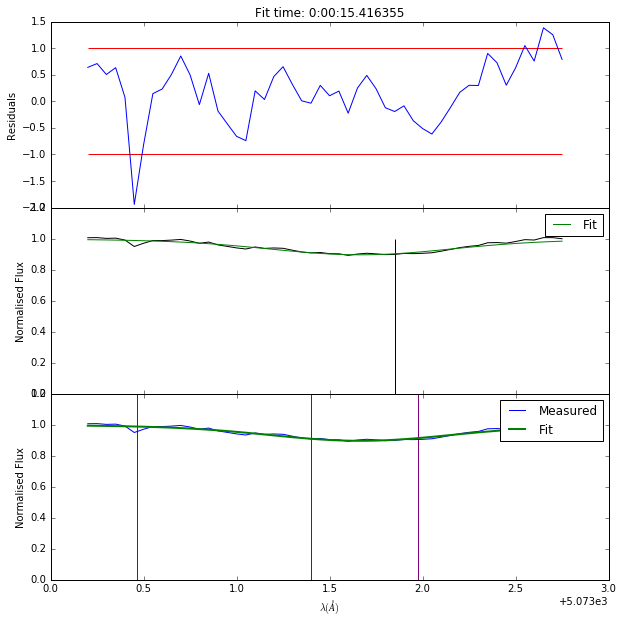

n: 5
Initialising Voigt profile components.
Computing the Maximum A Posteriori estimate...
n:  6
Initialising Voigt profile components.
Computing the Maximum A Posteriori estimate...
Fit 1 BIC:  -237.510258333 , Fit 2 BIC:  388.52228122
BIC Ratio:  -0.611316956101
n:  7
Initialising Voigt profile components.
Computing the Maximum A Posteriori estimate...
Fit 1 BIC:  388.52228122 , Fit 2 BIC:  472.882878406
BIC Ratio:  0.821603612569
n:  8
Initialising Voigt profile components.
Computing the Maximum A Posteriori estimate...
Fit 1 BIC:  472.882878406 , Fit 2 BIC:  332.819176755
BIC Ratio:  1.42084023828
n (final):  7
Using Metropolis step method for each parameter.
 [-----------------100%-----------------] 10000 of 10000 complete in 95.9 sec
Took: 0:01:35.903501  to finish.


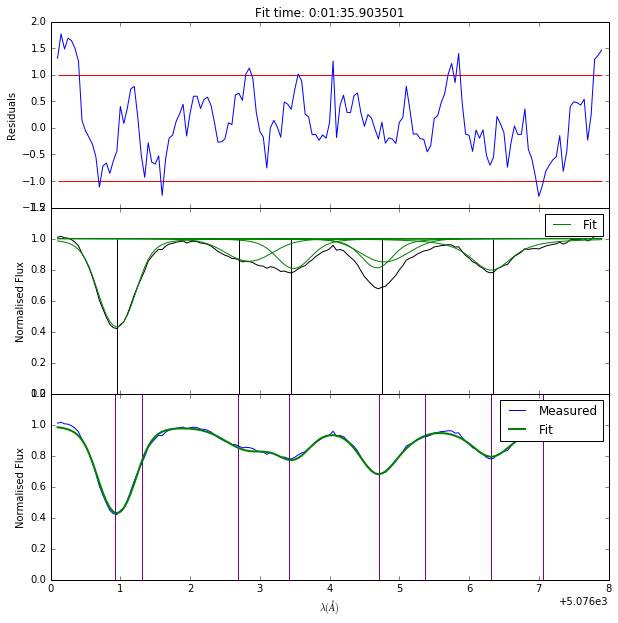

n: 3
Initialising Voigt profile components.
Computing the Maximum A Posteriori estimate...
n:  4
Initialising Voigt profile components.
Computing the Maximum A Posteriori estimate...
Fit 1 BIC:  -196.721582807 , Fit 2 BIC:  239.414562612
BIC Ratio:  -0.821677598307
n:  5
Initialising Voigt profile components.
Computing the Maximum A Posteriori estimate...
Fit 1 BIC:  239.414562612 , Fit 2 BIC:  239.996534037
BIC Ratio:  0.997575084042
n (final):  4
Using Metropolis step method for each parameter.
 [-----------------100%-----------------] 10000 of 10000 complete in 54.7 sec
Took: 0:00:54.735730  to finish.


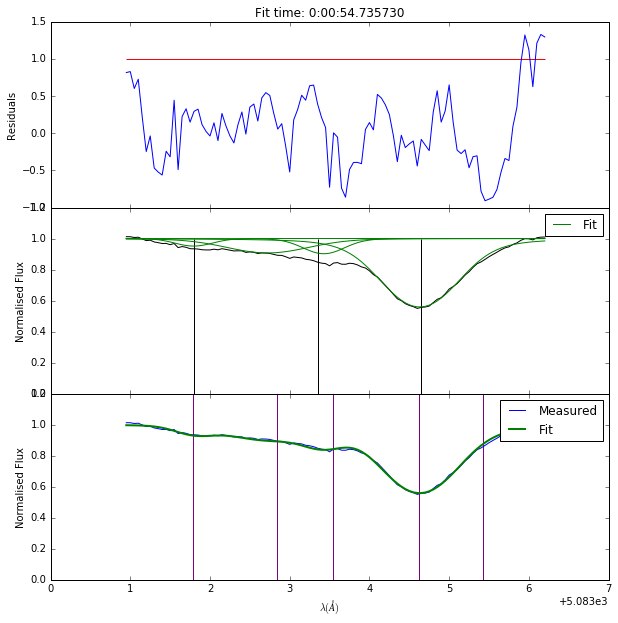

n: 7
Initialising Voigt profile components.
Computing the Maximum A Posteriori estimate...
n:  8
Initialising Voigt profile components.
Computing the Maximum A Posteriori estimate...
Fit 1 BIC:  251.534368363 , Fit 2 BIC:  481.507778287
BIC Ratio:  0.522389003262
n:  9
Initialising Voigt profile components.
Computing the Maximum A Posteriori estimate...
Fit 1 BIC:  481.507778287 , Fit 2 BIC:  597.738463689
BIC Ratio:  0.80554926199
n:  10
Initialising Voigt profile components.
Computing the Maximum A Posteriori estimate...
Fit 1 BIC:  597.738463689 , Fit 2 BIC:  647.913472072
BIC Ratio:  0.922559090764
n:  11
Initialising Voigt profile components.
Computing the Maximum A Posteriori estimate...
Fit 1 BIC:  647.913472072 , Fit 2 BIC:  3263.91975609
BIC Ratio:  0.198507782204
n:  12
Initialising Voigt profile components.
Computing the Maximum A Posteriori estimate...
Fit 1 BIC:  3263.91975609 , Fit 2 BIC:  684.660330362
BIC Ratio:  4.76721026668
n (final):  11
Using Metropolis step method

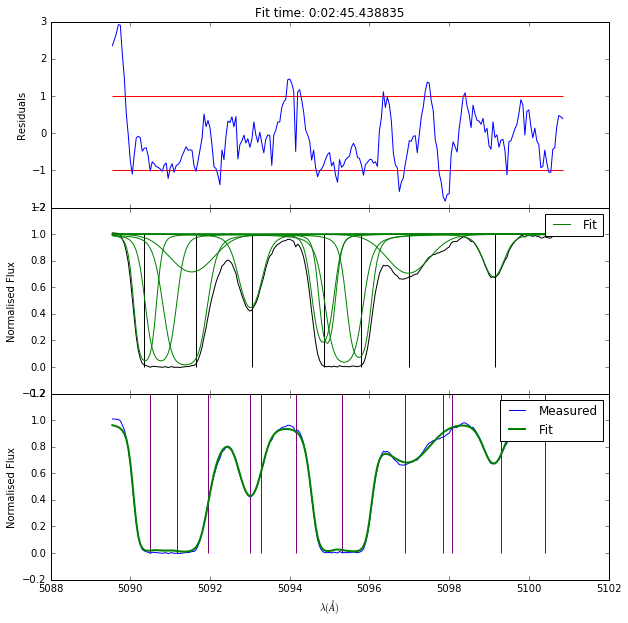

n: 3
Initialising Voigt profile components.
Computing the Maximum A Posteriori estimate...
n:  4
Initialising Voigt profile components.
Computing the Maximum A Posteriori estimate...
Fit 1 BIC:  -39.0585022233 , Fit 2 BIC:  123.21681854
BIC Ratio:  -0.316990023653
n:  5
Initialising Voigt profile components.
Computing the Maximum A Posteriori estimate...
Fit 1 BIC:  123.21681854 , Fit 2 BIC:  256.834665892
BIC Ratio:  0.479751509056
n:  6
Initialising Voigt profile components.
Computing the Maximum A Posteriori estimate...
Fit 1 BIC:  256.834665892 , Fit 2 BIC:  275.910351282
BIC Ratio:  0.930862741101
n:  7
Initialising Voigt profile components.
Computing the Maximum A Posteriori estimate...
Fit 1 BIC:  275.910351282 , Fit 2 BIC:  322.342743117
BIC Ratio:  0.855953351435
n:  8
Initialising Voigt profile components.
Computing the Maximum A Posteriori estimate...
Fit 1 BIC:  322.342743117 , Fit 2 BIC:  377.122314783
BIC Ratio:  0.854743223833
n:  9
Initialising Voigt profile components.

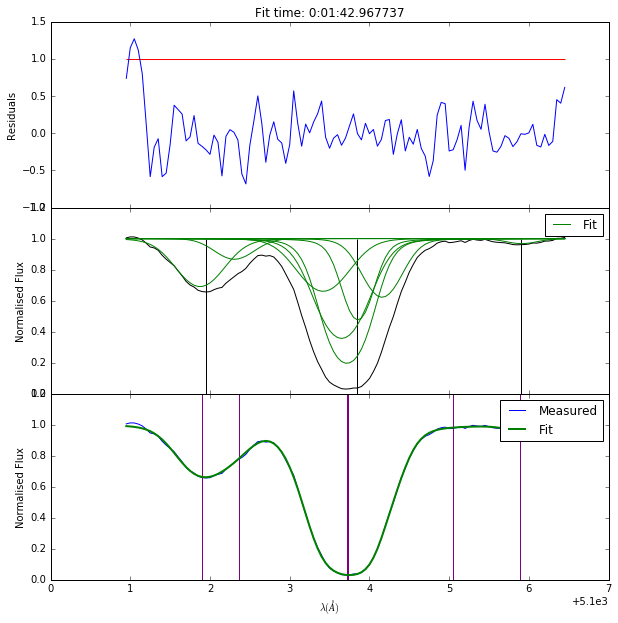

n: 6
Initialising Voigt profile components.
Computing the Maximum A Posteriori estimate...
n:  7
Initialising Voigt profile components.
Computing the Maximum A Posteriori estimate...
Fit 1 BIC:  96.9926641387 , Fit 2 BIC:  564.678344651
BIC Ratio:  0.17176621887
n:  8
Initialising Voigt profile components.
Computing the Maximum A Posteriori estimate...
Fit 1 BIC:  564.678344651 , Fit 2 BIC:  613.889578648
BIC Ratio:  0.919836993967
n:  9
Initialising Voigt profile components.
Computing the Maximum A Posteriori estimate...
Fit 1 BIC:  613.889578648 , Fit 2 BIC:  661.481349906
BIC Ratio:  0.928052739107
n:  10
Initialising Voigt profile components.
Computing the Maximum A Posteriori estimate...
Fit 1 BIC:  661.481349906 , Fit 2 BIC:  695.903294756
BIC Ratio:  0.950536309989
n (final):  9
Using Metropolis step method for each parameter.
 [-----------------100%-----------------] 10000 of 10000 complete in 135.7 sec
Took: 0:02:15.679104  to finish.


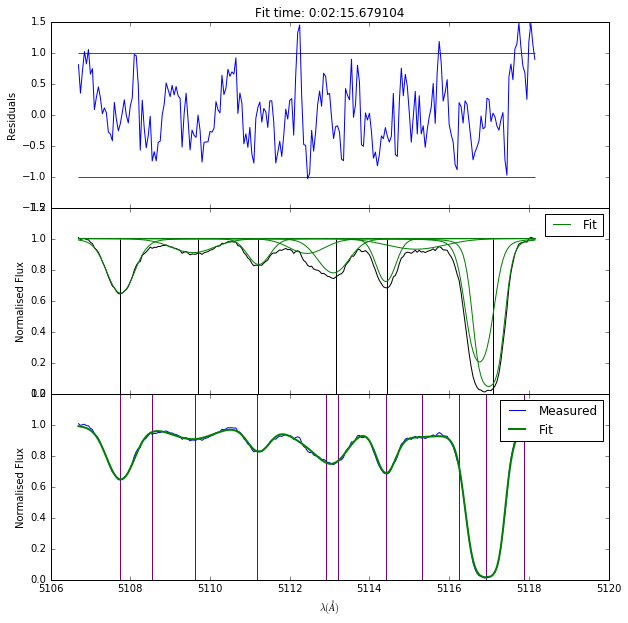

n: 1
Initialising Voigt profile components.
Computing the Maximum A Posteriori estimate...
n:  2
Initialising Voigt profile components.
Computing the Maximum A Posteriori estimate...
Fit 1 BIC:  -133.673114124 , Fit 2 BIC:  -37.1245233542
BIC Ratio:  3.60066883145
n (final):  1
Using Metropolis step method for each parameter.
 [-----------------100%-----------------] 10000 of 10000 complete in 15.5 sec
Took: 0:00:15.543910  to finish.


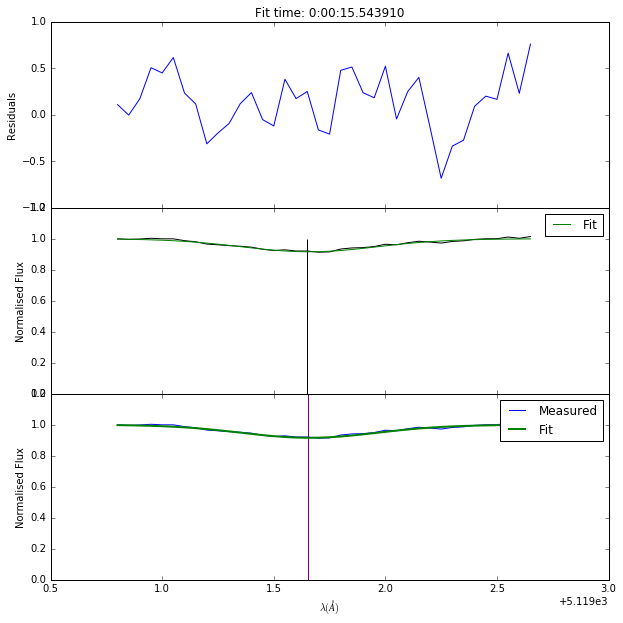

n: 6
Initialising Voigt profile components.
Computing the Maximum A Posteriori estimate...
n:  7
Initialising Voigt profile components.
Computing the Maximum A Posteriori estimate...
Fit 1 BIC:  963288.93434 , Fit 2 BIC:  559.97052632
BIC Ratio:  1720.24935075
n (final):  6
Using Metropolis step method for each parameter.
 [-----------------100%-----------------] 10000 of 10000 complete in 92.5 sec
Took: 0:01:32.474229  to finish.


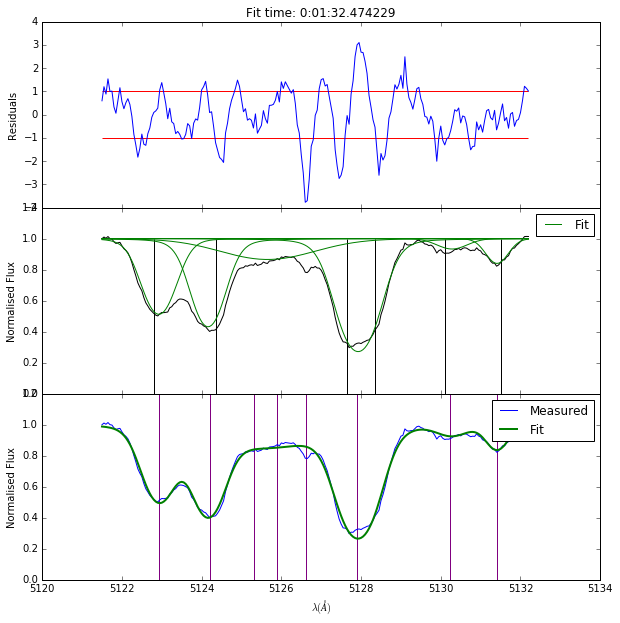

n: 6
Initialising Voigt profile components.
Computing the Maximum A Posteriori estimate...
n:  7
Initialising Voigt profile components.
Computing the Maximum A Posteriori estimate...
Fit 1 BIC:  228.423383226 , Fit 2 BIC:  451.588707291
BIC Ratio:  0.505821734553
n:  8
Initialising Voigt profile components.
Computing the Maximum A Posteriori estimate...
Fit 1 BIC:  451.588707291 , Fit 2 BIC:  594.519817067
BIC Ratio:  0.759585625789
n:  9
Initialising Voigt profile components.
Computing the Maximum A Posteriori estimate...
Fit 1 BIC:  594.519817067 , Fit 2 BIC:  19346.0992987
BIC Ratio:  0.0307307332547
n:  10
Initialising Voigt profile components.
Computing the Maximum A Posteriori estimate...
Fit 1 BIC:  19346.0992987 , Fit 2 BIC:  588.3818276
BIC Ratio:  32.8801781279
n (final):  9
Using Metropolis step method for each parameter.
 [-----------------100%-----------------] 10000 of 10000 complete in 127.6 sec
Took: 0:02:07.590763  to finish.


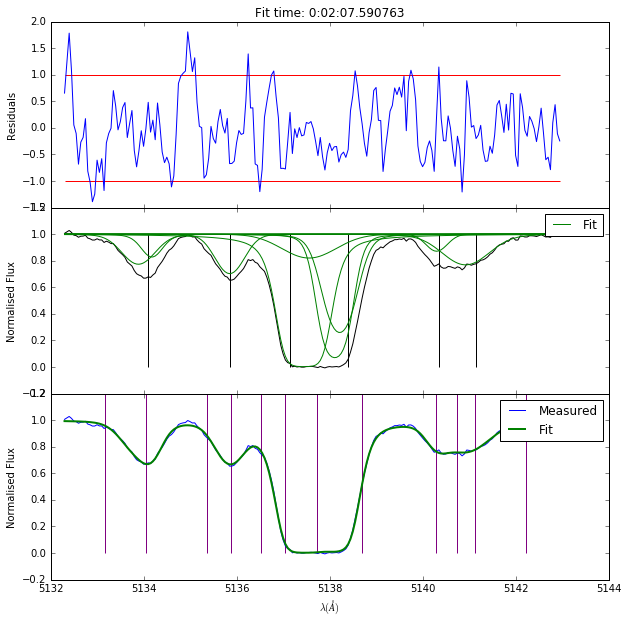

n: 4
Initialising Voigt profile components.
Computing the Maximum A Posteriori estimate...
n:  5
Initialising Voigt profile components.
Computing the Maximum A Posteriori estimate...
Fit 1 BIC:  -37.7193240617 , Fit 2 BIC:  303.475084847
BIC Ratio:  -0.124291337066
n:  6
Initialising Voigt profile components.
Computing the Maximum A Posteriori estimate...
Fit 1 BIC:  303.475084847 , Fit 2 BIC:  405.126200438
BIC Ratio:  0.749087776892
n:  7
Initialising Voigt profile components.
Computing the Maximum A Posteriori estimate...
Fit 1 BIC:  405.126200438 , Fit 2 BIC:  360.673612685
BIC Ratio:  1.12324879389
n (final):  6
Using Metropolis step method for each parameter.
 [-----------------100%-----------------] 10000 of 10000 complete in 90.9 sec
Took: 0:01:30.871845  to finish.


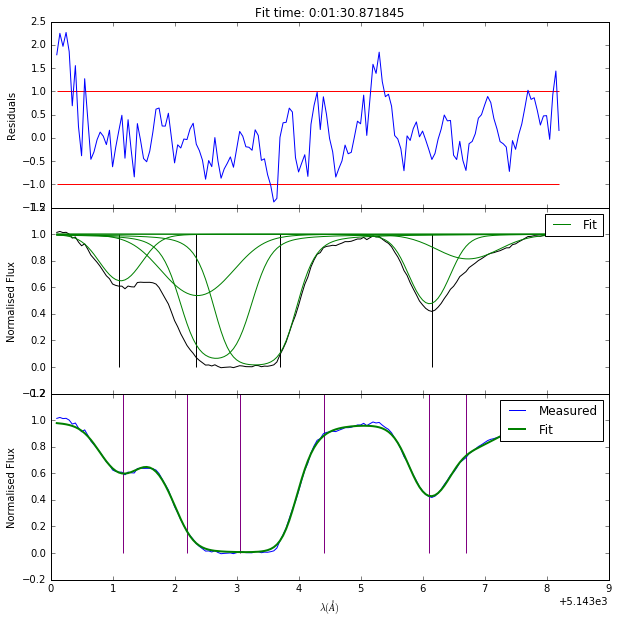

n: 1
Initialising Voigt profile components.
Computing the Maximum A Posteriori estimate...
n:  2
Initialising Voigt profile components.
Computing the Maximum A Posteriori estimate...
Fit 1 BIC:  -74.9246690041 , Fit 2 BIC:  47.2538155722
BIC Ratio:  -1.58557924047
n:  3
Initialising Voigt profile components.
Computing the Maximum A Posteriori estimate...
Fit 1 BIC:  47.2538155722 , Fit 2 BIC:  136.255093383
BIC Ratio:  0.34680403058
n:  4
Initialising Voigt profile components.
Computing the Maximum A Posteriori estimate...
Fit 1 BIC:  136.255093383 , Fit 2 BIC:  80.1528994391
BIC Ratio:  1.69993966951
n (final):  3
Using Metropolis step method for each parameter.
 [-----------------100%-----------------] 10001 of 10000 complete in 30.1 sec
Took: 0:00:30.077735  to finish.


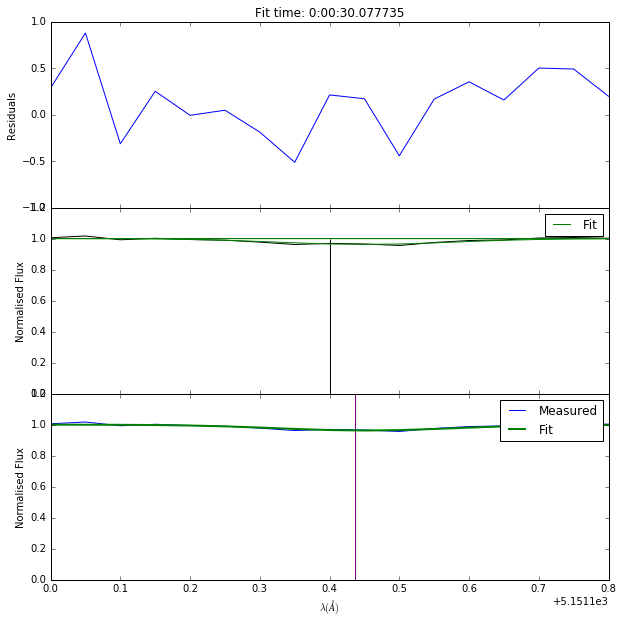

n: 7
Initialising Voigt profile components.
Computing the Maximum A Posteriori estimate...
n:  8
Initialising Voigt profile components.
Computing the Maximum A Posteriori estimate...
Fit 1 BIC:  164.579706546 , Fit 2 BIC:  558.433709219
BIC Ratio:  0.294716640183
n:  9
Initialising Voigt profile components.
Computing the Maximum A Posteriori estimate...
Fit 1 BIC:  558.433709219 , Fit 2 BIC:  536.822533402
BIC Ratio:  1.0402575795
n (final):  8
Using Metropolis step method for each parameter.
 [-----------------100%-----------------] 10000 of 10000 complete in 119.2 sec
Took: 0:01:59.173582  to finish.


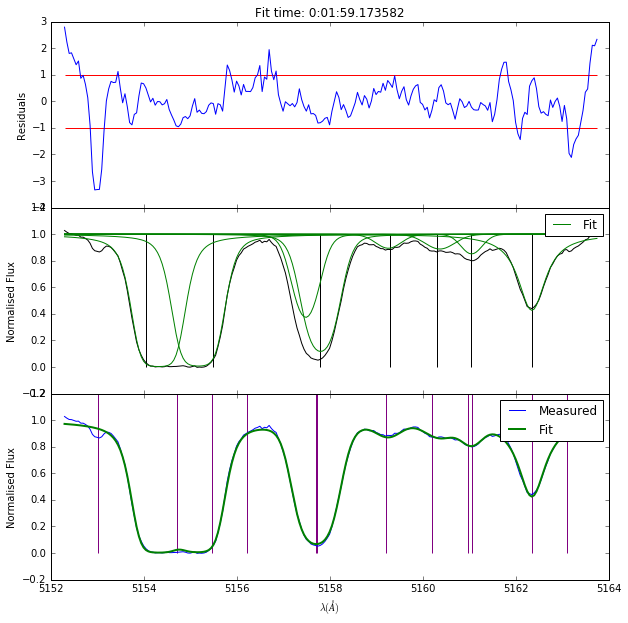

n: 10
Initialising Voigt profile components.
Computing the Maximum A Posteriori estimate...
n:  11
Initialising Voigt profile components.
Computing the Maximum A Posteriori estimate...
Fit 1 BIC:  382.033630408 , Fit 2 BIC:  879.244619788
BIC Ratio:  0.434502096243
n:  12
Initialising Voigt profile components.
Computing the Maximum A Posteriori estimate...
Fit 1 BIC:  879.244619788 , Fit 2 BIC:  687.781424461
BIC Ratio:  1.27837796794
n (final):  11
Using Metropolis step method for each parameter.
 [-----------------100%-----------------] 10000 of 10000 complete in 177.4 sec
Took: 0:02:57.446587  to finish.


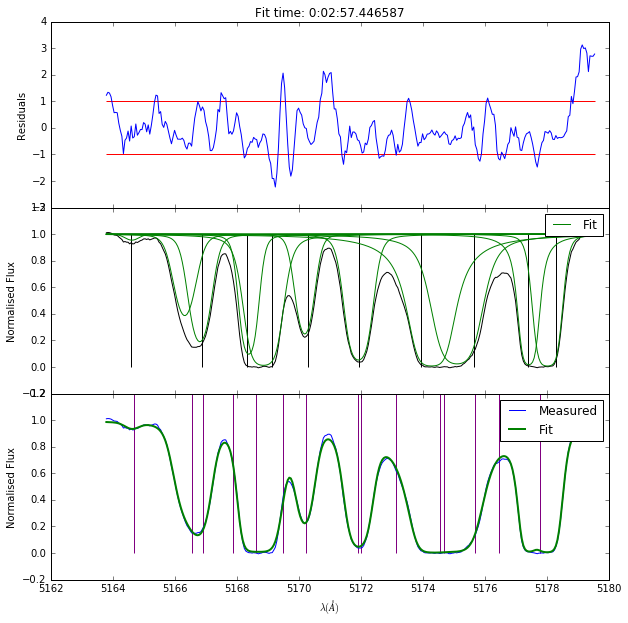

n: 10
Initialising Voigt profile components.
Computing the Maximum A Posteriori estimate...
n:  11
Initialising Voigt profile components.
Computing the Maximum A Posteriori estimate...
Fit 1 BIC:  455.761094489 , Fit 2 BIC:  857.024994735
BIC Ratio:  0.531794401901
n:  12
Initialising Voigt profile components.
Computing the Maximum A Posteriori estimate...
Fit 1 BIC:  857.024994735 , Fit 2 BIC:  987.182429159
BIC Ratio:  0.868152602215
n:  13
Initialising Voigt profile components.
Computing the Maximum A Posteriori estimate...
Fit 1 BIC:  987.182429159 , Fit 2 BIC:  1071.77517883
BIC Ratio:  0.921072300099
n:  14
Initialising Voigt profile components.
Computing the Maximum A Posteriori estimate...
Fit 1 BIC:  1071.77517883 , Fit 2 BIC:  697.209568242
BIC Ratio:  1.5372353273
n (final):  13
Using Metropolis step method for each parameter.
 [-----------------100%-----------------] 10000 of 10000 complete in 205.4 sec
Took: 0:03:25.562759  to finish.


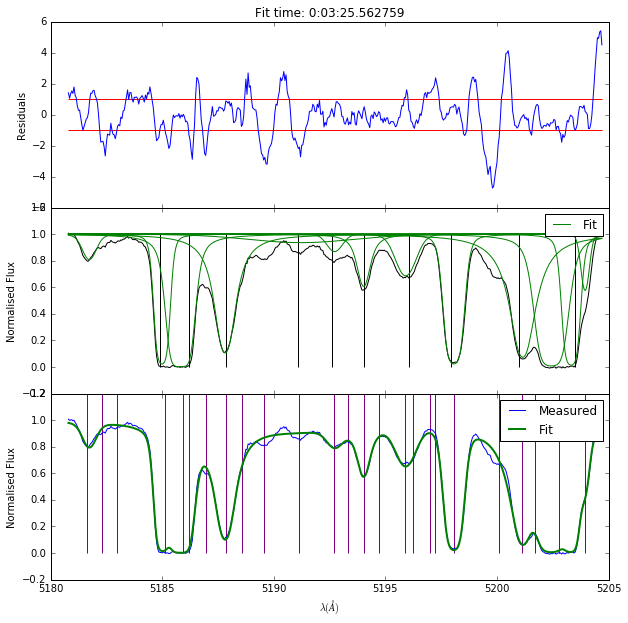

n: 1
Initialising Voigt profile components.
Computing the Maximum A Posteriori estimate...
n:  2
Initialising Voigt profile components.
Computing the Maximum A Posteriori estimate...
Fit 1 BIC:  -80.2575106482 , Fit 2 BIC:  26.8584040472
BIC Ratio:  -2.98817124454
n:  3
Initialising Voigt profile components.
Computing the Maximum A Posteriori estimate...


ZeroDivisionError: float division by zero

In [13]:
fits = []
window = 11

for i in np.arange(2, len(region_arrays)-2):
    
    wavelengths = region_arrays[i][0]
    fluxes = region_arrays[i][1]
    
    vpfit_2 = vpfits.VPfit()
    local_minima = vpfit_2.find_local_minima(fluxes, window=window)
    
    r = 0
    n = len(local_minima)
    
    print "n:", n
    
    vpfit_2.initialise_model(wavelengths, fluxes, n, local_minima, voigt=True)
    vpfit_2.map_estimate()

    while r < 0.95:

        n += 1
        print "n: ", n

        vpfit_1 = vpfit_2

        vpfit_2 = vpfits.VPfit()
        vpfit_2.initialise_model(wavelengths, fluxes, n, local_minima, voigt=True)
        vpfit_2.map_estimate()
        
        print "Fit 1 BIC: ", vpfit_1.MAP.BIC, ", Fit 2 BIC: ", vpfit_2.MAP.BIC
        print "BIC Ratio: ", vpfit_1.MAP.BIC / vpfit_2.MAP.BIC
        
        r = vpfit_1.MAP.BIC / vpfit_2.MAP.BIC
    
    n -= 1
    print "n (final): ", n
    vpfit_1.mcmc_fit()
    
    fits.append(vpfit_1)
    
    start = region_pixels[i][0]
    end = region_pixels[i][1]
    
    fig = vpfit_1.plot(wavelengths, fluxes, local_minima, n=n, start_pix=start, end_pix=end)
    
    fig.get_axes()[2].vlines(vpm[(vpm['wavelength_AA'] > wavelengths.min()) \
                & (vpm['wavelength_AA'] < wavelengths.max())]['wavelength_AA'], 
                0, #vpfit.Absorption(vpm[(vpm['wavelength_AA'] > wavelengths.min()) \
                   #    & (vpm['wavelength_AA'] < wavelengths.max())]['optical_depth']),
                1.2, color='purple')
    
    pylab.show()
    